In [2]:
!pip install transformers==4.35.2
!pip install datasets==2.15.0
!pip install evaluate==0.4.1
!pip install jiwer==3.0.3

  Obtaining dependency information for transformers==4.35.2 from https://files.pythonhosted.org/packages/12/dd/f17b11a93a9ca27728e12512d167eb1281c151c4c6881d3ab59eb58f4127/transformers-4.35.2-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 66.4 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: transformers
    Found existing installation: transformers 4.36.2
    Uninstalling transformers-4.36.2:
      Successfully uninstalled transformers-4.36.2
  Obtaining dependency information for datasets==2.15.0 from https://files.pythonhosted.org/packages/e2/cf/db41e572d7ed958e8679018f8190438ef700aeb501b62da9e1eed9e4d69a/datasets-2.15.0-py3-none-any.whl.metadata
  Obtaining dependency information for pyarrow-hotfix from https://files.pythonhosted.org/packages/e4/f4/9ec2222f5f5f8ea04f66f184caafd991a39c8782e31f5b0266f101cb68ca/pyarrow_hotfix-0.6-py3-none-any.whl.metadata
  Obtaining d

In [3]:
from huggingface_hub import notebook_login

notebook_login()

## Load the flickr8k captions dataset

In [4]:
from datasets import load_dataset

ds = load_dataset("Naveengo/flickr8k")
ds

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/8091 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 8091
    })
})

```bash
DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 8091
    })
})
```

The dataset has two features, `image` and `text`.

<Tip>

Many image captioning datasets contain multiple captions per image. In those cases, a common strategy is to randomly sample a caption amongst the available ones during training. 

</Tip>

Split the dataset’s train split into a train and test set with the [~datasets.Dataset.train_test_split] method:

In [5]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]

Let's visualize a couple of samples from the training set.

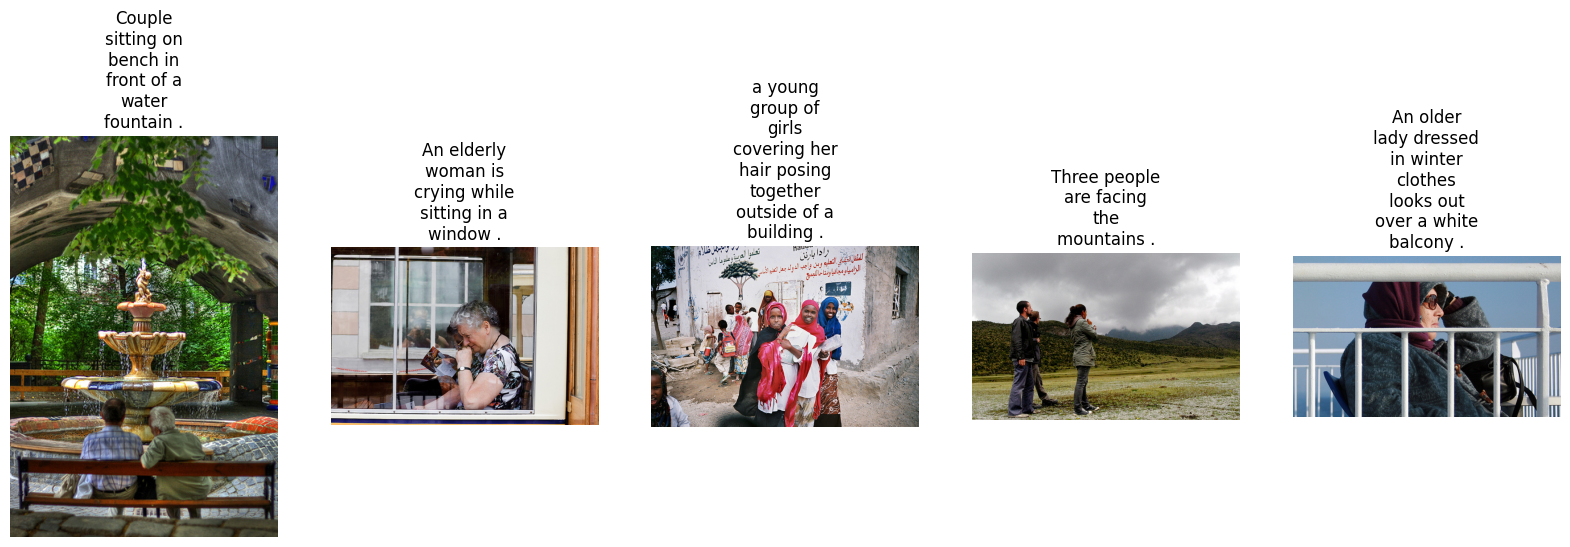

In [6]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

## Preprocess the dataset

In [7]:
from transformers import AutoProcessor

checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained(checkpoint)

preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [8]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

## Load a base model

Load the ["microsoft/git-base"](https://huggingface.co/microsoft/git-base) into a [`AutoModelForCausalLM`](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForCausalLM) object.

In [9]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

## Evaluate

Image captioning models are typically evaluated with the [Rouge Score](https://huggingface.co/spaces/evaluate-metric/rouge) or [Word Error Rate](https://huggingface.co/spaces/evaluate-metric/wer). For this guide, you will use the Word Error Rate (WER). 

We use the 🤗 Evaluate library to do so. For potential limitations and other gotchas of the WER, refer to [this guide](https://huggingface.co/spaces/evaluate-metric/wer).

In [10]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

## Train

Now, you are ready to start fine-tuning the model. You will use the 🤗 [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) for this. 

First, define the training arguments using [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments).

In [11]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]


training_args=TrainingArguments(
    output_dir=f"{model_name}-flickr8k",
    learning_rate=5e-5,
    num_train_epochs=30,
    fp16=True,
    per_device_train_batch_size=8, # to fit lower memory GPUs
#     per_device_eval_batch_size=2, # to fit lower memory GPUs, it can be 16 or 32
    gradient_accumulation_steps=2,
    save_total_limit=3,
#     evaluation_strategy="steps",
#     eval_steps=50,
    save_strategy="epoch",
    save_steps=10,
    logging_steps=5,
    remove_unused_columns=False,
    push_to_hub=True,
    label_names=["labels"],
#     load_best_model_at_end=True,
#     report_to="wandb", # or report_to="tensorboard"
#     run_name=os.getenv("WANDB_NAME"),
)

trainer=Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

trainer.train()

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss
5,10.206400
10,8.801000
15,8.168900
20,7.641000
25,7.150600
30,6.656200
35,6.141000
40,5.622000
45,5.090300
50,4.548600


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

TrainOutput(global_step=6840, training_loss=0.07416824495019426, metrics={'train_runtime': 21326.7213, 'train_samples_per_second': 10.242, 'train_steps_per_second': 0.321, 'total_flos': 1.0215591857989632e+17, 'train_loss': 0.07416824495019426, 'epoch': 30.0})

In [12]:
trainer.push_to_hub()

CommitInfo(commit_url='https://huggingface.co/Adesh696/git-base-flickr8k/commit/8407cbe7f2498a7d6d20a851174bb9d17d0bf092', commit_message='End of training', commit_description='', oid='8407cbe7f2498a7d6d20a851174bb9d17d0bf092', pr_url=None, pr_revision=None, pr_num=None)

## Inference 

Take a sample image from `test_ds` to test the model.

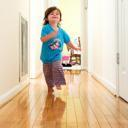

In [16]:
from PIL import Image
import requests

# url = "https://datasets-server.huggingface.co/cached-assets/aharma/flickr30k_dogs_and_babies_128/--/51db49748afca157c5593c9773773706c394a491/--/default/test/6/image/image.jpg"
url = "https://datasets-server.huggingface.co/cached-assets/aharma/flickr30k_dogs_and_babies_128/--/51db49748afca157c5593c9773773706c394a491/--/default/test/7/image/image.jpg"
image = Image.open(requests.get(url, stream=True).raw)
image

    Prepare image for the model.

In [17]:
device = "cuda" if torch.cuda.is_available() else "cpu"

inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

Call `generate` and decode the predictions.

In [18]:
generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

a little girl in pajamas runs down a hall with hardwood floors.
